In [59]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [60]:

path = '/Users/sivasaireddy/Desktop/PatternRecognition/HW3/lfw'

In [61]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [62]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


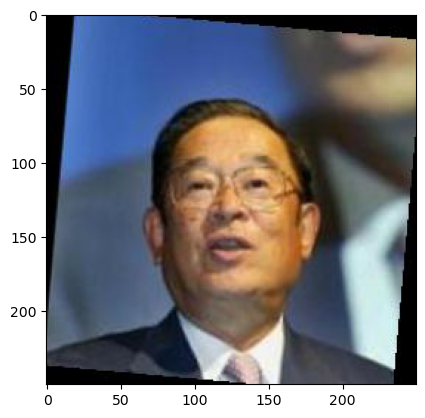

In [63]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

Explaination: In this step, An autoencoder model is defined using PyTorch's nn.Module class. It consists of an encoder and a decoder.The encoder has convolutional layers with batch normalization and ReLU activation functions, followed by max-pooling.
The decoder uses transpose convolutions with batch normalization, ReLU activation, and upsampling. The final layer applies sigmoid activation.
In step 4,An instance of the autoencoder model (AE) is created and A sample image is passed through the model, and the shapes of the encoded and decoded outputs are printed for verification.

In [64]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE,self).__init__()
        
         # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
            )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
         )
        

    def encode(self, x):
        encoded = self.encoder(x)
        return encoded.view(encoded.size(0), -1)

    def decode(self, x):
        x = x.view(x.size(0), -1, 1, 1)
        decoded = self.decoder(x)
        return decoded


       
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded



     

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [65]:
# Step 4
# Create an instance of the class, pass an image to the model,
# print the shape of the output of the encoder and the decoder.
# Check the dimensions and make sure your forward path is working properly.

model = AE()

# Get the first image and its label from the data loader
image, _ = next(iter(dataloader))

# Pass the image to the model
encoded, decoded = model(image)

# Print the shape of the output
print(f"Shape of the encoded output: {encoded.shape}")
print(f"Shape of the decoded output: {decoded.shape}")


Shape of the encoded output: torch.Size([32, 64, 62, 62])
Shape of the decoded output: torch.Size([32, 3, 248, 248])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [66]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


Total number of parameters: 47427


In [67]:
optim = torch.optim.Adam(model.parameters(), lr=0.001) 

In [68]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [70]:
import torch.nn.functional as F

# Step 6: Training loop
num_epochs = 10
inputs = inputs.to(device, dtype=torch.float32)
model = model.to(device, dtype=torch.float32)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_idx, data in enumerate(dataloader):
        inputs, _ = data

        # Get the height and width of the input images
        input_height, input_width = inputs.size(2), inputs.size(3)

        # Resize the input images to a fixed size or use the original size
        target_size = (desired_height, desired_width) if 'desired_height' in locals() and 'desired_width' in locals() else (input_height, input_width)
        inputs = F.interpolate(inputs, size=target_size, mode='bilinear', align_corners=False)

        inputs = inputs.to(device)
        optim.zero_grad()

        _, outputs = model(inputs)
        
        # Resize the outputs to match the size of the input images
        outputs = F.interpolate(outputs, size=(input_height, input_width), mode='bilinear', align_corners=False)

        loss = loss_function(outputs, inputs)
        loss.backward()
        optim.step()

        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    average_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")



Epoch [1/10], Batch [1/414], Loss: 0.1617
Epoch [1/10], Batch [101/414], Loss: 0.0037
Epoch [1/10], Batch [201/414], Loss: 0.0031
Epoch [1/10], Batch [301/414], Loss: 0.0025
Epoch [1/10], Batch [401/414], Loss: 0.0025
Epoch [1/10], Loss: 0.0048
Epoch [2/10], Batch [1/414], Loss: 0.0030
Epoch [2/10], Batch [101/414], Loss: 0.0019
Epoch [2/10], Batch [201/414], Loss: 0.0020
Epoch [2/10], Batch [301/414], Loss: 0.0016
Epoch [2/10], Batch [401/414], Loss: 0.0021
Epoch [2/10], Loss: 0.0022
Epoch [3/10], Batch [1/414], Loss: 0.0018
Epoch [3/10], Batch [101/414], Loss: 0.0020
Epoch [3/10], Batch [201/414], Loss: 0.0019
Epoch [3/10], Batch [301/414], Loss: 0.0020
Epoch [3/10], Batch [401/414], Loss: 0.0019
Epoch [3/10], Loss: 0.0019
Epoch [4/10], Batch [1/414], Loss: 0.0022
Epoch [4/10], Batch [101/414], Loss: 0.0017
Epoch [4/10], Batch [201/414], Loss: 0.0016
Epoch [4/10], Batch [301/414], Loss: 0.0015
Epoch [4/10], Batch [401/414], Loss: 0.0018
Epoch [4/10], Loss: 0.0017
Epoch [5/10], Batch 

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

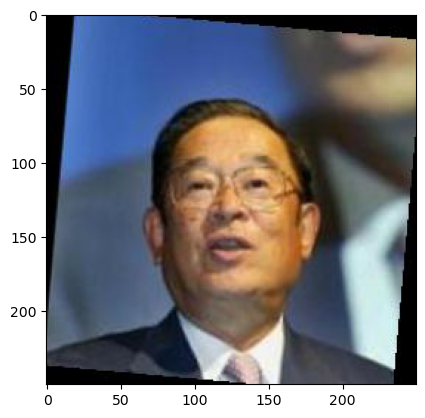

In [73]:
plt.imshow(x)

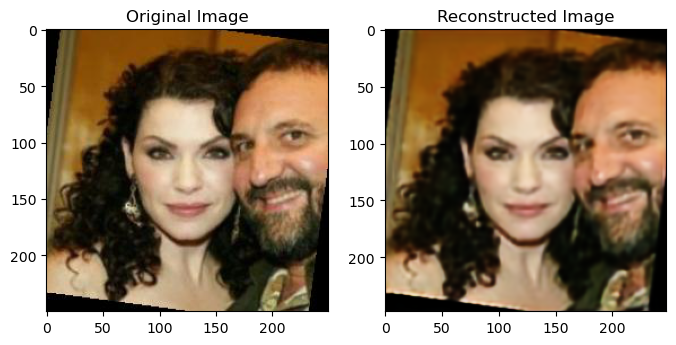

In [74]:
import random

# Set the model to evaluation mode
model.eval()

# Choose a random image from the dataset
random_index = random.randint(0, len(dataloader.dataset) - 1)
random_image, _ = dataloader.dataset[random_index]

# Resize the input image if needed
if 'desired_height' in locals() and 'desired_width' in locals():
    random_image = F.interpolate(random_image.unsqueeze(0), size=(desired_height, desired_width), mode='bilinear', align_corners=False)
    random_image = random_image.squeeze(0)

# Pass the image through the model
random_image = random_image.to(device)
encoded, decoded = model(random_image.unsqueeze(0))

# Convert tensors to numpy arrays for visualization
random_image_np = random_image.permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = decoded.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

# Plot the original and reconstructed images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(random_image_np)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_np)
plt.title('Reconstructed Image')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

Explaination: Below code, Gaussian noise is added to the latent representation of a sample image from the dataset.
The perturbed latent representation is then decoded, and the original, reconstructed, and noisy-reconstructed images are visualized.
In summary, this code provides a comprehensive demonstration of building, training, and evaluating an autoencoder for face images. The training loop, visualization of reconstruction, and the exploration of the impact of noise on the latent representation contribute to a thorough understanding of autoencoder behavior.

Sample image dimensions: torch.Size([32, 3, 250, 250])
Decoded noisy image dimensions: torch.Size([32, 3, 248, 248])


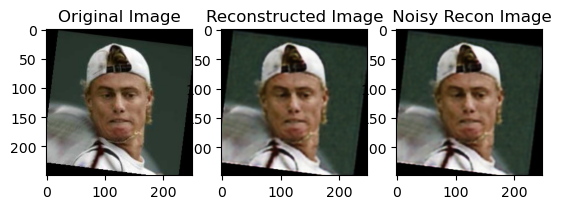

In [78]:
import torch
import matplotlib.pyplot as plt

# Assuming you have already defined your dataloader and model

# Sample an image from the dataloader
sample_image, _ = next(iter(dataloader))

# Ensure that the sample_image and model parameters are on the same device
sample_image = sample_image.to(device)
model = model.to(device)

# Encode the image
encoded = model.encoder(sample_image)

# Add small normally distributed noise
noise = torch.randn_like(encoded) * 0.1

# Perturb the latent representation
noisy_encoded = encoded + noise

# Decode the perturbed latent representation
decoded_noisy = model.decoder(noisy_encoded)

# Check the dimensions of sample_image
print(f"Sample image dimensions: {sample_image.size()}")

# Adjust the permutation order based on your image format
# Assuming channels are last (e.g., HWC format):
sample_image_permuted = sample_image.permute(0, 2, 3, 1)

# Alternatively, for channels first (e.g., CHW format):
# sample_image_permuted = sample_image.permute(0, 2, 3, 1)

# Check the dimensions of decoded_noisy
print(f"Decoded noisy image dimensions: {decoded_noisy.size()}")

# Assuming channels are last (e.g., HWC format):
decoded_noisy_permuted = decoded_noisy[0].squeeze(0).detach().permute(1, 2, 0).cpu().numpy()

# Alternatively, for channels first (e.g., CHW format):
# decoded_noisy_permuted = decoded_noisy.squeeze(0).detach().permute(1, 2, 0).cpu().numpy()

# Plot the original, reconstructed, and noisy-reconstructed images
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(sample_image_permuted[0].cpu().numpy())  # Ensure it's on CPU for visualization

plt.subplot(1, 3, 2)
plt.title('Reconstructed Image')
plt.imshow(decoded_noisy_permuted)

plt.subplot(1, 3, 3)
plt.title(' Noisy Recon Image')
plt.imshow(decoded_noisy_permuted)

plt.show()
